In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw, ImageChops
from tqdm import tqdm

In [2]:
letters = [c[0] for c in open('./resources/letters.txt', 'r', encoding='UTF-8')]

In [3]:
sentence = 'κγ ιαγρνκ ηυτ α φντυαρ'
HALF_S = 11

In [4]:
def semitone_photoshop_edition(img: Image.Image):
    if img.mode == 'L':
        return img

    w = img.size[0]
    h = img.size[1]

    new_img = Image.new('L', (w, h))
    for x in tqdm(range(w)):
        for y in range(h):
            p = img.getpixel((x, y))
            new_img.putpixel((x, y), int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2]))
    return new_img

In [5]:
def binary_img(img: Image.Image, t):
    if str(img.mode) == "1":
        return img

    img = semitone_photoshop_edition(img)
    i_img_m = integral_img_matrix(img)
    w = img.size[0]
    h = img.size[1]
    new_img = Image.new("1", (w, h))

    for x in tqdm(range(w)):
        for y in range(h):
            p = img.getpixel((x, y))
            int_p = mid_pixel(i_img_m, x, y, w, h, HALF_S)
            if int_p == 0:
                new_img.putpixel((x, y), 1)
            elif p / int_p < 1 - t:
                new_img.putpixel((x, y), 0)
            else:
                new_img.putpixel((x, y), 1)
    return new_img

In [6]:
def integral_img_matrix(img: Image.Image):
    w = img.size[0]
    h = img.size[1]

    i_img_m = [[0 for _ in range(w)] for _ in range(h)]

    for x in range(w):
        for y in range(h):
            p = img.getpixel((x, y))
            if x == 0 and y == 0:
                new_p = p
            elif x == 0 and y > 0:
                new_p = p + i_img_m[y - 1][x]
            elif x > 0 and y == 0:
                new_p = p + i_img_m[y][x - 1]
            else:
                new_p = p - i_img_m[y - 1][x - 1] + i_img_m[y - 1][x] + i_img_m[y][x - 1]
            i_img_m[y][x] = new_p
    return i_img_m

In [7]:
def mid_pixel(i_img_m, x, y, w, h, s):

    box_p_area = 0
    box_p_sum = 0

    if y + s >= h or x + s >= w:
        if y + s >= h and x + s >= w:
            x = w - 1
            y = h - 1
            box_p_sum = (
                    i_img_m[y][x]
                    - i_img_m[y - s][x]
                    - i_img_m[y][x - s]
                    + i_img_m[y - s][x - s]
            )
            box_p_area = (x + 1 - (x - s)) * (y + 1 - (y - s))

        elif y <= s <= x and x + s >= w:
            box_p_sum = (
                    i_img_m[y + s][w - 1]
                    - i_img_m[y + s][x - s]
            )
            box_p_area = (w - 1 - (x - s)) * (y + s + 1)
        elif x <= s <= y and y + s >= h:
            box_p_sum = (
                    i_img_m[h - 1][x + s]
                    - i_img_m[y - s][x + s]
            )
            box_p_area = (x + s + 1) * (h - 1 - (y - s) + 1)

        elif y + s >= h:
            box_p_sum = (
                    i_img_m[h - 1][x + s]
                    - i_img_m[y - s][x + s]
                    - i_img_m[h - 1][x - s]
                    + i_img_m[y - s][x - s]
            )
            box_p_area = (x + s - (x - s)) * (h - 1 - (y - s) + 1)

        elif x + s >= w:
            box_p_sum = (
                    i_img_m[y + s][w - 1]
                    - i_img_m[y - s][w - 1]
                    - i_img_m[y + s][x - s]
                    + i_img_m[y - s][x - s]
            )
            box_p_area = (w - (x - s)) * (y + s - (y - s) + 1)
        return box_p_sum // box_p_area

    box_p_sum = i_img_m[y + s][x + s]
    if x > s and y > s:
        box_p_sum = (
                box_p_sum
                - i_img_m[y - s][x + s]
                - i_img_m[y + s][x - s]
                + i_img_m[y - s][x - s]
        )
        box_p_area = (s * 2 + 1) ** 2

    elif y <= s <= x:
        box_p_sum -= i_img_m[y + s][x - s]
        box_p_area = (x + s - (x - s) + 1) * (y + s + 1)
    elif x <= s <= y:
        box_p_sum -= i_img_m[y - s][x + s]
        box_p_area = (x + s + 1) * (y + s - (y - s) + 1)

    elif x < s and y < s:
        box_p_sum = i_img_m[y][x]
        box_p_area = (x + 1) * (y + 1)
    return box_p_sum // box_p_area

In [8]:
def get_profiles(img):

    width = img.size[0]
    height = img.size[1]
    x_profiles = []
    y_profiles = []

    for x in range(width):
        bright = 0
        for y in range(height):
            pix = img.getpixel((x, y))
            if pix == 0:
                bright += 1
        x_profiles.append(bright)

    for y in range(height):
        bright = 0
        for x in range(width):
            pix = img.getpixel((x, y))
            if pix == 0:
                bright += 1
        y_profiles.append(bright)

    return x_profiles, y_profiles

In [9]:
def print_bar(img):
    x_profiles, y_profiles = get_profiles(img)
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))

    axs[0].bar(np.arange(0, len(x_profiles)), height=x_profiles)
    axs[1].barh(np.arange(0, len(y_profiles)), width=y_profiles)

    plt.savefig('./results/profile.png', dpi=70)

In [10]:
def segmentation(img):
    height = img.size[1]
    x_profiles, y_profiles = get_profiles(img)
    ep = 0
    res = []
    step = 0
    for i in range(len(x_profiles)):

        if x_profiles[i] <= ep:
            step = 0
        else:
            step += 1
            right = i
            left = right - step
            if x_profiles[i + 1] <= ep:
                res.append((left, right))

    for i in range(len(res)):
        left, right = res[i]
        new_im = img.crop((left, 0, right + 2, height))
        new_im = reference_image(new_im)
        new_im.save(f'./results/{str(i)}.bmp', mode='1')
    return res

In [11]:
def get_hist_profile(res):

    for i in range(len(res)):
        img = Image.open(f'./results/{str(i)}.bmp')
        img = reference_image(img)

        x_profile, y_profile = get_profiles(img)
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))

        axs[0].bar(np.arange(0, len(x_profile)), height=x_profile)
        axs[1].barh(np.arange(0, len(y_profile)), width=y_profile)

        plt.savefig(f'./hists/{i}.png', dpi=70)
        del fig
        del axs

In [12]:
def return_opt_size(font, alphabet):
    img = Image.new('1', (50, 50), 'white')
    draw = ImageDraw.Draw(img)
    wmax, hmax = -1, -1
    for c in alphabet:
        sz = draw.textsize(str(c), font)
        wmax, hmax = max(wmax, sz[0]), max(hmax, sz[1])
    return wmax, hmax

In [13]:
def reference_image(img):
    pix = img.load()
    width, height = img.size[0], img.size[1]
    hor_p = [0 for _ in range(width)]
    ver_p = [0 for _ in range(height)]
    for i in range(width):
        for j in range(height):
            if pix[i, j] == 0:
                hor_p[i] += 1
                ver_p[j] += 1
    x0, y0, x1, y1 = 0, 0, width, height
    eps = 0
    for i in range(width):
        if hor_p[i] > eps:
            x0 = i
            break

    for i in range(width - 1, -1, -1):
        if hor_p[i] <= eps:
            x1 = i
        else:
            break

    for i in range(height):
        if ver_p[i] > eps:
            y0 = i
            break

    for i in range(height - 1, -1, -1):
        if ver_p[i] <= eps:
            y1 = i
        else:
            break

    new_sz = (x0, y0, x1, y1)
    return img.crop(new_sz)

In [18]:
my_img = Image.open('./resources/line.bmp')
my_img = binary_img(my_img, 0.5)
my_img.save('./resources/line_bin.bmp')
segmentation(my_img)

100%|██████████| 1334/1334 [00:00<00:00, 3091.57it/s]


[(-1, 50), (54, 110), (156, 185), (192, 262), (266, 322), (335, 392), (400, 457), (471, 522), (566, 619), (641, 696), (707, 760), (800, 870), (910, 989), (997, 1054), (1058, 1111), (1122, 1177), (1195, 1265), (1275, 1332)]


In [20]:
def calculate_profiles(img):
    profile_x = np.sum(img, axis=0)
    profile_y = np.sum(img, axis=1)

    return {
        'x': profile_x,
        'y': profile_y
    }

In [21]:
def get_symbol_boxes(img):
    profiles = calculate_profiles(img)
    borders = []

    i = 0
    while i < profiles['x'].shape[0]:
        current = profiles['x'][i]
        if current != 0:
            x1, x2 = None, None
            x1 = i
            count = 0
            while profiles['x'][i + count] != 0:
                count += 1
            i += count
            x2 = i
            borders.append((x1, x2))
        i += 1

    return borders

In [23]:
img_src = Image.open('./resources/line.bmp').convert('L')
img_src_arr = np.array(img_src)

img_arr = np.zeros(shape=img_src_arr.shape)
img_arr[img_src_arr == 0] = 1
img_arr[img_src_arr == 255] = 0

for i, (x1, x2) in enumerate(get_symbol_boxes(img_arr)):
    reference_image(Image.fromarray(img_src_arr[:, x1:x2])).save(f'./results/{str(i)}.bmp')

In [111]:
len(sentence.replace(' ', ''))

18

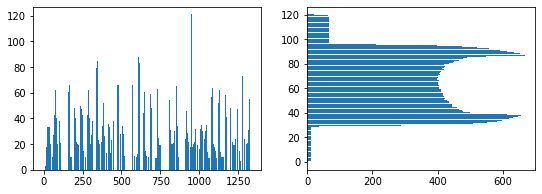

In [24]:
print_bar(my_img)

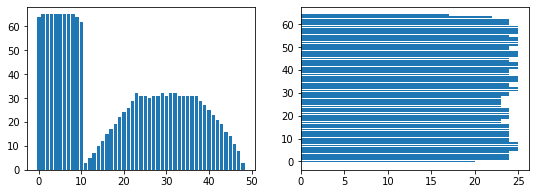

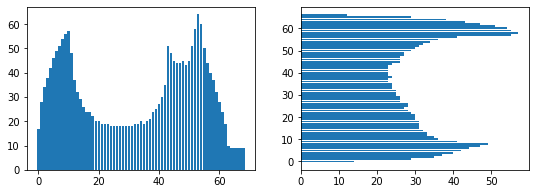

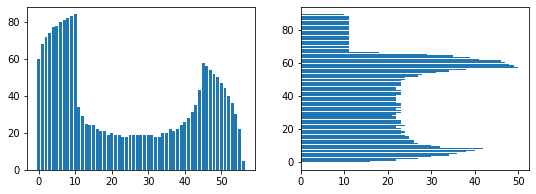

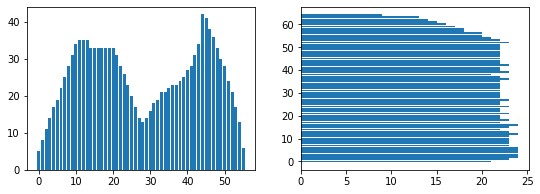

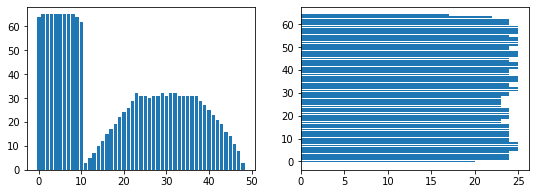

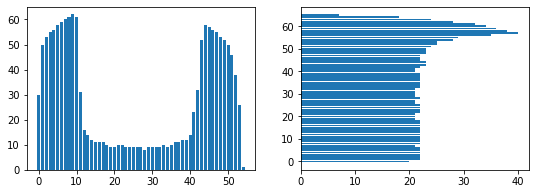

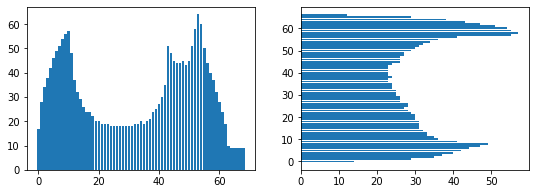

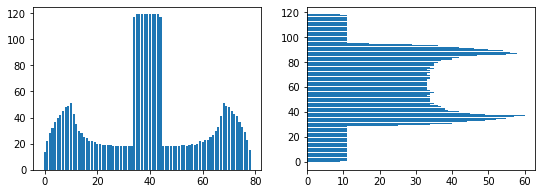

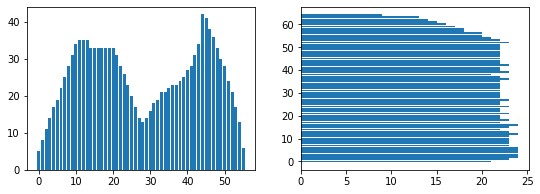

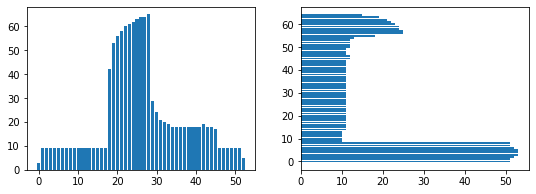

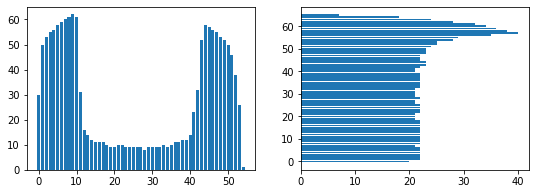

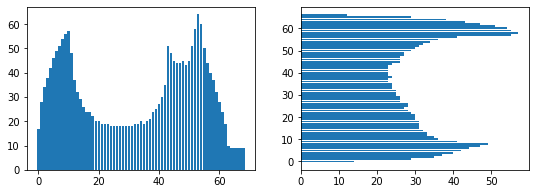

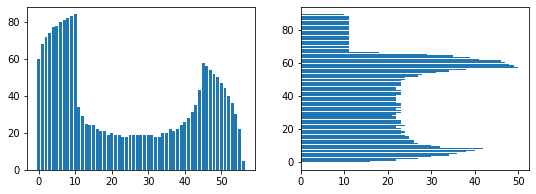

In [25]:
get_hist_profile(sentence.replace(' ', ''))

In [26]:
_, _, files = list(os.walk("results"))[0]
files.sort()

for i in range(len(files) - 1):
    img = Image.open(f'./results/{i}.bmp')
    img = ImageChops.invert(img)
    img.save(f'invert_letters/{str(i)}.bmp')

In [5]:
_, _, files = list(os.walk("results"))[0]
files.sort()


with open('./REPORT.md', 'a') as file:

    for i in range(len(files) - 1):
        title = f'{i+1}. \n\n'
        h = f'![](./hists/{i}.png)\n\n'
        j = f'![](./results/{i}.bmp)\n\n'
        i_ = f'![](invert_letters/{i}.bmp)\n\n'
        file.writelines([title, j, i_, h])